In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from pixelgrid import *
from psfmodel import *

In [2]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner

In [4]:
plt.rcParams['figure.dpi'] = 100

In [5]:
#%% obs grid
Nx, Ny = 30*10, 30*10
pix = PixelGrid(0, Nx, 0, Ny)

#%% true grid (oversample)
oversample_true = 10
spix = PixelGrid(0, Nx, 0, Ny, dx=1./oversample_true, dy=1./oversample_true)

In [6]:
# conversion from supersampled to observed grid
M, N = spix.X.shape
K, L = oversample_true, oversample_true
MK, NL = M // K, N // L
@jit
def super_to_obs(Zsuper):
    return Zsuper[:MK*K, :NL*L].reshape(MK, K, NL, L).sum(axis=(1, 3))

In [7]:
truepsffunc = gaussian_psf

In [8]:
xcenters = np.array([15., 24.2, 5.4, 7.3, 12.1, 20, 24])
ycenters = np.array([19.2, 5.5, 6.0, 22., 12.1, 25, 25])
truepsfkws = {"sigma": 1}

In [9]:
Nsource = 10*2
np.random.seed(124)
xcenters = np.random.rand(Nsource)*Nx
ycenters = np.random.rand(Nsource)*Ny

In [74]:
def super_image(spix, xcenters, ycenters, psffunc, **kwargs):
    ret = np.zeros_like(spix.X)
    for x, y in zip(xcenters, ycenters):
        sZ = truepsffunc(spix.X, spix.Y, x, y, **kwargs)
        ret += sZ / jnp.sum(sZ)
    return np.array(ret)

def plot2d(Z, pix, xcenters=None, ycenters=None, title=None):
    plt.imshow(Z, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    plt.xlabel("x pixel")
    plt.ylabel("y pixel")
    if xcenters is not None:
        for x, y in zip(xcenters, ycenters):
            plt.axvline(x=x, color='gray', lw=1, alpha=0.5)
            plt.axhline(y=y, color='gray', lw=1, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.colorbar();

In [75]:
Zs = super_image(spix, xcenters, ycenters, truepsffunc, **truepsfkws)

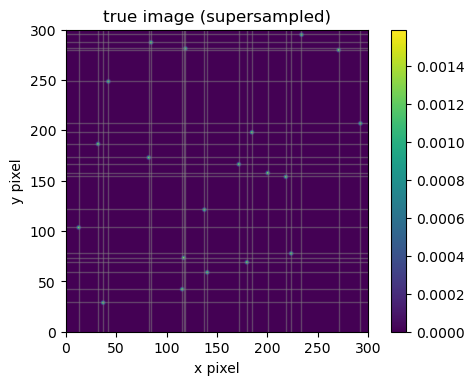

In [76]:
plot2d(Zs, spix, xcenters=xcenters, ycenters=ycenters, title="true image (supersampled)")

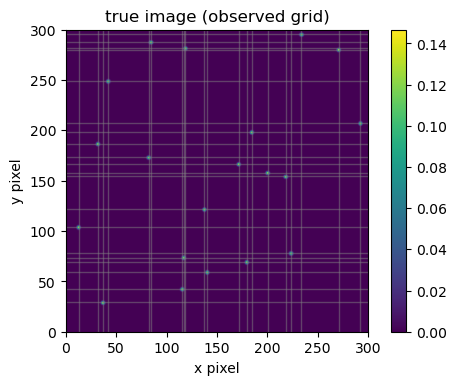

In [77]:
Z = super_to_obs(Zs)
plot2d(Z, pix, xcenters=xcenters, ycenters=ycenters, title="true image (observed grid)")

In [78]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*np.shape(Z))*sigmaerr
Zobs = Z + Zerr

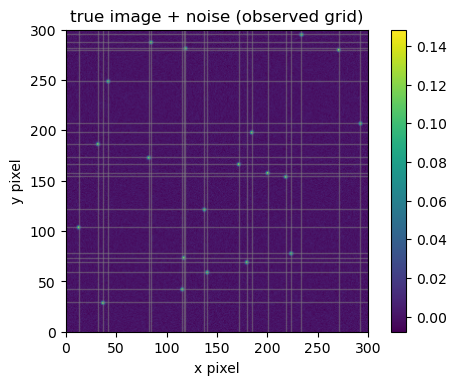

In [79]:
plot2d(Zobs, pix, xcenters=xcenters, ycenters=ycenters, title="true image + noise (observed grid)")

In [16]:
# define supersampled ePSF
xext, yext = 7., 7.
dx, dy = 1./2., 1./2.
dx, dy = 1./3., 1./3.
#dx, dy = 1./4., 1./4. # failed
#dx, dy = 1., 1.
"""
xext, yext = 9., 9.
dx, dy = 1./3., 1./3.
xext, yext = 9., 9.
dx, dy = 1., 1.
xext, yext = 9., 9.
dx, dy = 0.5, 0.5
"""
gpsf = GridPSFModel(xext, yext, dx, dy)
gpsfvalues = vmap(gpsf.psfvalues, (None,None,0,0,None), 0)

PSF grid shape: (21, 21)


In [33]:
from tinygp import kernels, GaussianProcess
from jax.scipy.special import logsumexp
width = 2.
shift = 0.
def gpmodel(Z, sigmaerr, gpsf, xcenters, ycenters):
    ones = jnp.ones_like(xcenters) 
    c = numpyro.sample("c", dist.TruncatedNormal(loc=ones, scale=ones, low=ones*0.))
    x = numpyro.sample("x", dist.Uniform(low=xcenters[1:]-width, high=xcenters[1:]+width))
    y = numpyro.sample("y", dist.Uniform(low=ycenters[1:]-width, high=ycenters[1:]+width))
    xc = jnp.r_[xcenters[0]+shift, x]
    yc = jnp.r_[ycenters[0]+shift, y]
    
    nones = jnp.ones(gpsf.Nparams)
    _alphas = numpyro.sample("_alphas", dist.Uniform(low=-30.*nones, high=-jnp.log(gpsf.ds)*nones))
    alphas  = numpyro.deterministic("alphas", _alphas - (jnp.log(gpsf.ds) + logsumexp(_alphas)))
    psfpdfs = numpyro.deterministic("psfpdfs", jnp.exp(alphas))
    numpyro.deterministic("psfpdfsum", jnp.sum(psfpdfs) * gpsf.ds)
    alpha_mean = -jnp.log(gpsf.ds*gpsf.Nparams)
    
    super_image = jnp.sum(gpsfvalues(spix.X, spix.Y, xc, yc, jnp.exp(alphas)) * spix.ds * c[:,None,None], axis=0)
    obs_image = super_to_obs(super_image)
    numpyro.deterministic("super_image", super_image)
    numpyro.deterministic("obs_image", obs_image)
    numpyro.sample("obs", dist.Normal(obs_image, sigmaerr), obs=Z)
    
    # GP regularization
    lnlenx = numpyro.sample("lnlenx", dist.Uniform(low=-2+2, high=3+2))
    lnleny = numpyro.sample("lnleny", dist.Uniform(low=-2+2, high=3+2))
    lna = numpyro.sample("lna", dist.Uniform(low=-2+2, high=5+2))
    lnsigma = numpyro.sample("lnsigma", dist.Uniform(-10+2, -5+2))  # don't know why this works better
    #lnsigma = -5.
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    kernel = kernels.ExpSquared(jnp.array([lenx, leny]))
    kernel = jnp.exp(2*lna) * kernel
    X = jnp.array([gpsf.X1d, gpsf.Y1d]).T
    gp = GaussianProcess(kernel, X, diag=jnp.exp(2*lnsigma), mean=alpha_mean)
    loglike_gp = gp.condition(alphas)
    numpyro.factor("loglike_gp", loglike_gp)
    
    # smoothness prior
    """
    alphas_grid = alphas.reshape((gpsf.Ny, gpsf.Nx))
    xdiff = jnp.diff(alphas_grid, axis=1)
    ydiff = jnp.diff(alphas_grid, axis=0)
    lneps = numpyro.sample("lneps", dist.Uniform(low=0, high=5))
    loglike_reg = -0.5 * jnp.exp(lneps) * (jnp.sum(xdiff**2) + jnp.sum(ydiff**2)) + 0.5 * (gpsf.Nparams-1) * lneps
    numpyro.factor("loglike_reg", loglike_reg)
    """

In [34]:
kernel = numpyro.infer.NUTS(gpmodel)

In [35]:
nw, ns = 500, 500
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [36]:
rng_key = random.PRNGKey(0)

In [37]:
mcmc.run(rng_key, Zobs, sigmaerr, gpsf, xcenters, ycenters)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|█████████████████████████████████████████████| 1000/1000 [3:34:28<00:00, 12.87s/it, 127 steps of size 1.93e-02. acc. prob=0.63]


In [38]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  _alphas[0]    -20.25      0.38    -20.22    -20.93    -19.71      6.33      1.25
  _alphas[1]    -19.26      0.34    -19.21    -19.89    -18.81      5.26      1.30
  _alphas[2]    -18.37      0.31    -18.28    -18.96    -17.98      4.56      1.36
  _alphas[3]    -17.58      0.30    -17.47    -18.14    -17.24      4.15      1.42
  _alphas[4]    -16.88      0.29    -16.78    -17.42    -16.56      3.92      1.46
  _alphas[5]    -16.30      0.29    -16.20    -16.82    -15.99      3.82      1.49
  _alphas[6]    -15.81      0.29    -15.71    -16.35    -15.52      3.81      1.50
  _alphas[7]    -15.43      0.29    -15.33    -15.93    -15.10      3.86      1.50
  _alphas[8]    -15.16      0.29    -15.05    -15.66    -14.82      3.90      1.50
  _alphas[9]    -15.00      0.30    -14.89    -15.49    -14.63      3.94      1.51
 _alphas[10]    -14.95      0.30    -14.83    -15.43    -14.54      4.00      1.51
 _a

In [39]:
from arviz import plot_trace

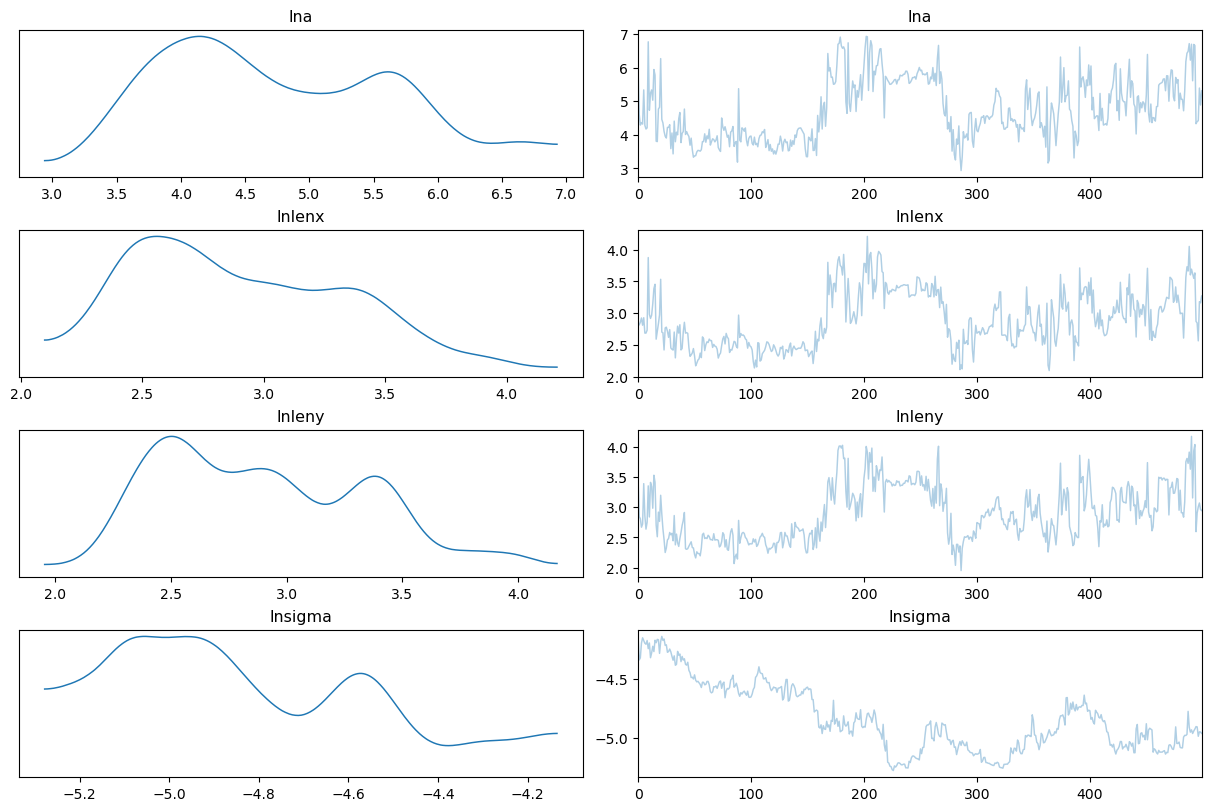

In [40]:
#fig = plot_trace(mcmc, var_names=['lneps'])
fig = plot_trace(mcmc, var_names=['lna', 'lnlenx', 'lnleny', 'lnsigma'])

In [41]:
smp = mcmc.get_samples()

In [42]:
imkey = 'Zpsf_obs'
imkey = 'obs_image'
mean_model = np.mean(smp[imkey], axis=0)

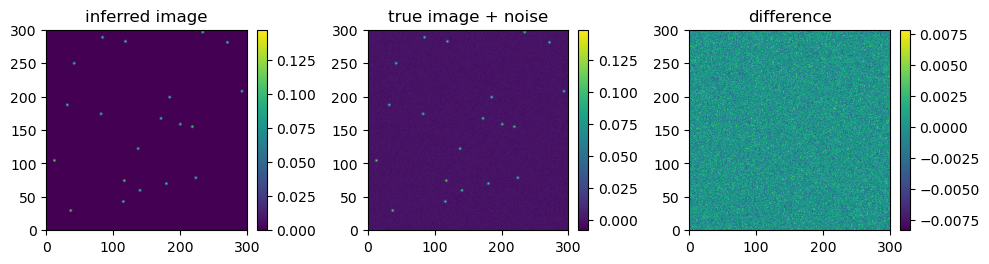

In [43]:
fig, ax = plt.subplots(1,3,figsize=(10,10))
for i,(image,title) in enumerate(zip([mean_model, Zobs, mean_model-Zobs], 
                                     ['inferred image', 'true image + noise', 'difference'])):
    im = ax[i].imshow(image, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    ax[i].set_title(title)
fig.tight_layout()

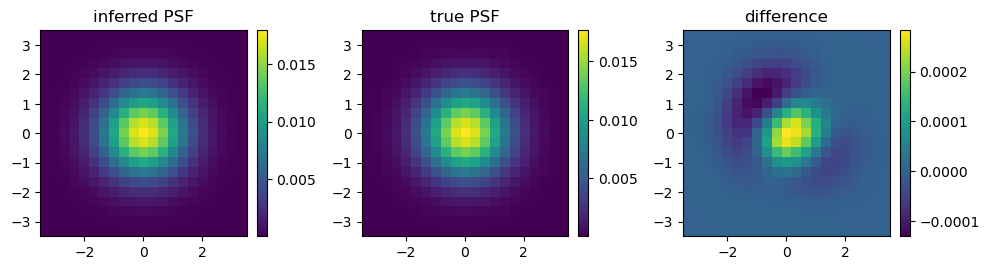

In [44]:
Xg, Yg = np.meshgrid(gpsf.xgrid_center, gpsf.ygrid_center)
pmean = np.exp(np.mean(smp['alphas'], axis=0))
meanpsf = gpsf.psfvalues(Xg, Yg, 0, 0, pmean)
truepsf = truepsffunc(Xg, Yg, 0, 0, **truepsfkws)
meanpsf /= np.sum(meanpsf)
truepsf /= np.sum(truepsf)
fig, ax = plt.subplots(1,3,figsize=(10,10))
for i,(image,title) in enumerate(zip([meanpsf, truepsf, meanpsf-truepsf], ['inferred PSF', 'true PSF', 'difference'])):
    im = ax[i].imshow(image, origin='lower', extent=[gpsf.xgrid_edge[0], gpsf.xgrid_edge[-1], gpsf.ygrid_edge[0], gpsf.ygrid_edge[-1]])
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    ax[i].set_title(title)
fig.tight_layout()

In [45]:
xmean, xstd = np.mean(smp['x'], axis=0), np.std(smp['x'], axis=0)
ymean, ystd = np.mean(smp['y'], axis=0),np.std(smp['y'], axis=0)

In [46]:
dmax = np.r_[np.abs(xmean-xcenters[1:]-shift)+np.abs(xstd), np.abs(ymean-ycenters[1:]-shift)+np.abs(ystd)].max()

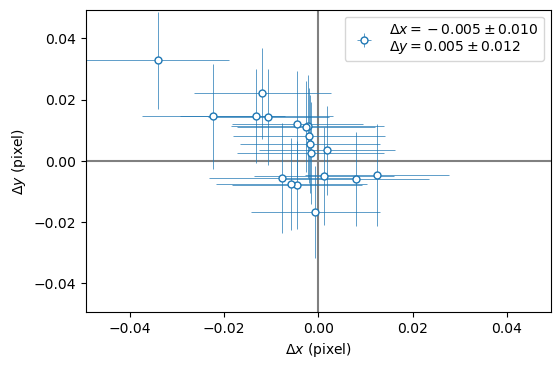

In [61]:
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
dx = xmean-xcenters[1:]-shift
dy = ymean-ycenters[1:]-shift
plt.errorbar(dx, dy, xerr=xstd, yerr=ystd, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best')

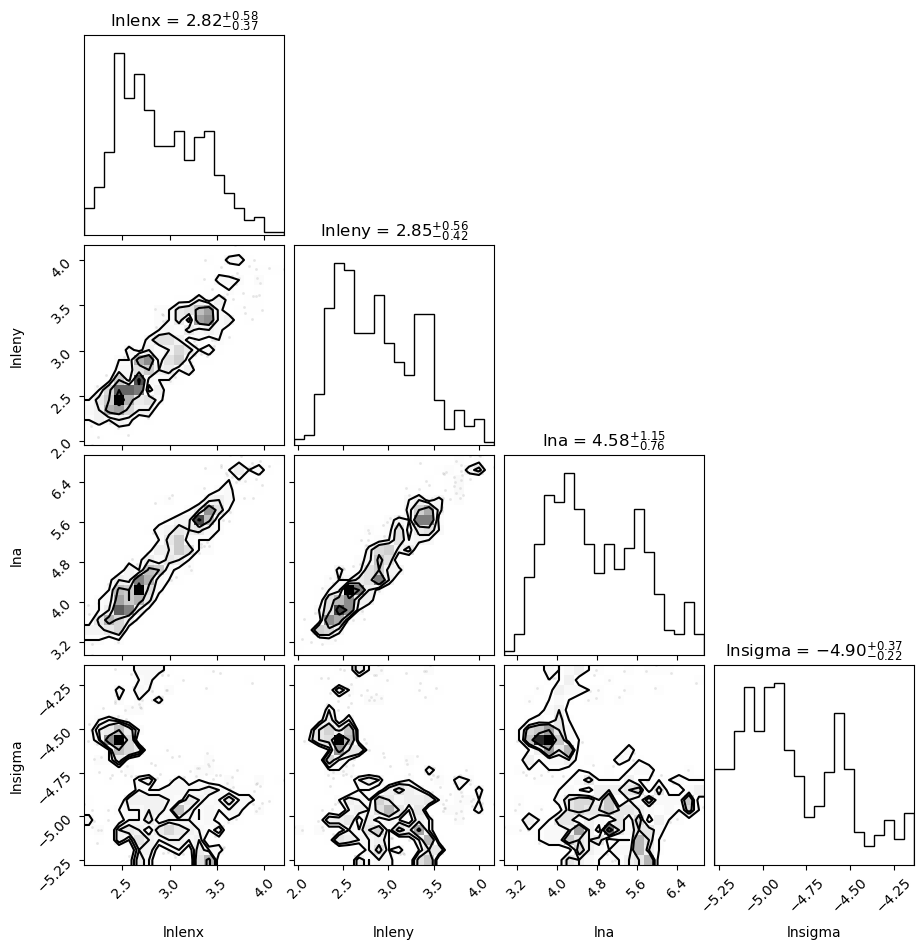

In [49]:
import pandas as pd
pnames = ["lnlenx", "lnleny", "lna", "lnsigma"]
hyper = pd.DataFrame(data=dict(zip(pnames, [smp[k] for k in pnames])))
fig = corner.corner(hyper, labels=pnames, show_titles="%.2f")